# Pangenome taxonomy node classification

## Setup

In [23]:
## Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [24]:
# Notebook imports
import ast
import os
import pickle
from IPython.display import display

from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [25]:
DATASET_DIR = './dataset/'
EVALS_DIR = './evals/'
PROJECTION_NAME_PREFIX = 'ml_projection_'
RANDOM_SEED = 42

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

In [17]:
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)


def set_class_labels(df):
    # Binary class, rank: phylum, 1547 examples
    df['isPisuviricota'] = 0
    df.loc[df['phylum'] == 'Pisuviricota', 'isPisuviricota'] = 1

    # Binary class, rank: order, 878 examples
    df['isPicornavirales'] = 0
    df.loc[df['order'] == 'Picornavirales', 'isPicornavirales'] = 1
    
    # Binary class, rank:  order, 1672 examples
    df['isEllioviricetes'] = 0
    df.loc[df['order'] == 'Ellioviricetes', 'isEllioviricetes'] = 1
    
    # Binary class, rank: family, 615 examples
    df['isPicornaviridae'] = 0
    df.loc[df['family'] == 'Picornaviridae', 'isPicornaviridae'] = 1

    # Binary class, rank:  genus, 77 examples
    df['isOrthoflavivirus'] = 0
    df.loc[df['genus'] == 'Orthoflavivirus', 'isOrthoflavivirus'] = 1


def get_projection(gds, projection_name, class_label = 'isPisuviricota'):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    
    nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    set_class_labels(nodes)
    nodes['labels'] = nodes['nodeLabels']
    nodes = nodes.loc[
        (nodes['labels'] != 'Fasta') |
        (nodes['isSegmented'] == False)
    ]
    nodes = nodes[[
        'nodeId',
        'labels',
        'degree',
        class_label,
    ]]
    
    relationships = pd.read_csv(DATASET_DIR + 'pangenome_edges.csv')
    relationships = relationships[[
        'sourceNodeId',
        'targetNodeId',
        'relationshipType',
        'weight'
    ]]

    undirected_relationship_types = relationships['relationshipType'].unique().tolist()
    # test
    undirected_relationship_types.remove('hasHit')
    undirected_relationship_types.remove('hasRegion')
    # undirected_relationship_types.remove('hasAffiliate')
    undirected_relationship_types.remove('hasDownstream')
    # undirected_relationship_types.remove('hasMember')
    
    projection = gds.graph.construct(
        graph_name=projection_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=undirected_relationship_types,
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


In [18]:
version = 1
available_class_labels = [
    'topPhylum',
    'isPisuviricota',
    'isPicornavirales',
]
class_label = available_class_labels[2]
projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name, class_label=class_label)
print(projection)

Graph(name=ml_projection_1, node_count=148782, relationship_count=630160)


## Train-eval pipeline

In [19]:
# Configure pipeline

pipeline_name = 'taxon_prediction_pipeline'
TEST_FRACTION = 0.3
VALIDATION_FOLDS = 5  # used to tune hyperparameters and determine best model

if gds.beta.pipeline.exists(pipeline_name)['exists']:
    gds.beta.pipeline.drop(gds.pipeline.get(pipeline_name))

model_encoder = 'fastRP'

pipeline, _ = gds.beta.pipeline.nodeClassification.create(pipeline_name)

G = gds.graph.get(projection_name)

if model_encoder == 'fastRP':
    pipeline.addNodeProperty(
        procedure_name=model_encoder,
        mutateProperty=model_encoder,
        embeddingDimension=384,
        randomSeed=RANDOM_SEED,
        # featureProperties=["features"],
        relationshipWeightProperty='weight',
        normalizationStrength=-0.5,
        # nodeSelfInfluence=2,
        contextRelationshipTypes=[
            "*"
            # "hasHit",
            # "hasRegion",
            # "hasAffiliate",
            # "hasMember",
            # "hasDownstream",
        ],
        contextNodeLabels=[
            "*"
            # 'FuncDomainSet',
            # 'FuncDomainClan',
            # 'FuncDomain', # 
            # 'Genome', #
        ],
    )
    pipeline.selectFeatures([model_encoder])


split = pipeline.configureSplit(
    testFraction=TEST_FRACTION,
    validationFolds=VALIDATION_FOLDS,
)

# pipeline.addLogisticRegression(penalty=(0.1, 2))
# pipeline.addLogisticRegression(maxEpochs=200, penalty=(0.0, 2))
# pipeline.addRandomForest(maxDepth=(2, 100))

# Last layer should match number of classes being predicted
# pipeline.addMLP(hiddenLayerSizes=[16, 16, 4], penalty=1, patience=2)
# pipeline.addMLP(hiddenLayerSizes=[128, 64, 2], maxEpochs=100, patience=10)
# [128, 256, 128, 2]
# [256, 128, 2] *
# [256, 384, 256, 128, 2]
pipeline.addMLP(
    hiddenLayerSizes=[384, 128, 2],
    maxEpochs=100,
    patience=10,
    focusWeight=0.5,
)

name                                         taxon_prediction_pipeline
nodePropertySteps    [{'name': 'gds.fastRP.mutate', 'config': {'ran...
featureProperties                                             [fastRP]
splitConfig                {'testFraction': 0.3, 'validationFolds': 5}
autoTuningConfig                                     {'maxTrials': 10}
parameterSpace       {'MultilayerPerceptron': [{'minEpochs': 1, 'ma...
Name: 0, dtype: object

In [20]:
# Run the train and eval pipeline

# CALL gds.beta.listProgress()
if gds.beta.model.exists(model_encoder)['exists']:
    gds.beta.model.drop(gds.model.get(model_encoder))

model, evals = pipeline.train(
    pipeline=pipeline,
    G=gds.graph.get(projection_name),
    modelName=model_encoder,
    targetNodeLabels=['Fasta'],
    targetProperty=class_label,
    randomSeed=RANDOM_SEED,
    metrics=[ # First metric is used for determining winning model in k-fold validation
        'F1_WEIGHTED',
        'F1_MACRO',
        'ACCURACY',
        'OUT_OF_BAG_ERROR',
        'RECALL(class=*)',
        'F1(class=*)',
        'PRECISION(class=*)',
        'ACCURACY(class=*)',
    ],
)

evals.to_csv(EVALS_DIR + class_label + '_evals.csv')

display(evals['modelInfo']['bestParameters'])

print('-----------------')

print('Best model metrics (general):')
print('Accuracy:')
display(evals['modelInfo']['metrics']['ACCURACY'])
print('F1 weighted:')
display(evals['modelInfo']['metrics']['F1_WEIGHTED'])
print('F1 macro:')
display(evals['modelInfo']['metrics']['F1_MACRO'])

print('-----------------')
print('Best model metrics (all)')
# display(evals['modelInfo']['metrics'])

# display(evals['modelSelectionStats'])


Node Classification Train Pipeline: 100%|██████████| 100.0/100 [18:19<00:00, 11.00s/%]


{'minEpochs': 1,
 'maxEpochs': 100,
 'focusWeight': 0.5,
 'patience': 10,
 'tolerance': 0.001,
 'learningRate': 0.001,
 'hiddenLayerSizes': [384, 128, 2],
 'batchSize': 100,
 'penalty': 0.0,
 'methodName': 'MultilayerPerceptron',
 'classWeights': []}

-----------------
Best model metrics (general):
Accuracy:


{'test': 0.96940929,
 'validation': {'min': 0.95706215,
  'max': 0.9661017,
  'avg': 0.9629133139999999},
 'outerTrain': 0.99231118,
 'train': {'min': 0.99462822, 'max': 0.99575912, 'avg': 0.995081428}}

F1 weighted:


{'test': 0.9678545612875055,
 'validation': {'min': 0.9540282554371056,
  'max': 0.9644957938935091,
  'avg': 0.9606301574314984},
 'outerTrain': 0.9922275858707096,
 'train': {'min': 0.9945872582940244,
  'max': 0.9957343647140986,
  'avg': 0.995048617598135}}

F1 macro:


{'test': 0.929309754646938,
 'validation': {'min': 0.8973443173657865,
  'max': 0.9221407574533811,
  'avg': 0.9126919832685326},
 'outerTrain': 0.9834932198234749,
 'train': {'min': 0.9885402859197623,
  'max': 0.9909845379531146,
  'avg': 0.9895267389357256}}

-----------------
Best model metrics (all)


## Exhaustive predictions

In [21]:
# Get predictions and confidence for all genome nodes

nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
nodes['labels'] = nodes['nodeLabels']
set_class_labels(nodes)

predicted = model.predict_stream(
    G=gds.graph.get(projection_name),
    modelName=model_encoder,
    includePredictedProbabilities=True,
    targetNodeLabels=['Fasta']
)
classes = evals["modelInfo"]["classes"]
predicted['confidence'] = predicted.apply(
    lambda row: np.floor(row["predictedProbabilities"][classes.index(row["predictedClass"])] * 100), axis=1
)
min_confidence = predicted['confidence'].min()
max_confidence = predicted['confidence'].max()
predicted['confidenceNormalized'] = (predicted['confidence'] - min_confidence) / (max_confidence - min_confidence) 

genome_nodes = nodes.loc[nodes['nodeLabels'] == 'Fasta', [
    'nodeId',
    'appId',
    class_label,
    'labels',
    'accession',
    'degree',
    'species',
    'genus',
    'family',
    'order',
    'class',
    'phylum',
]]
pred_genome_nodes = genome_nodes.merge(predicted, left_on='nodeId', right_on='nodeId', how='left')
pred_genome_nodes['correct'] = pred_genome_nodes.apply(lambda row: row['predictedClass'] == row[class_label], axis=1)
exported_genome_nodes = pred_genome_nodes[[
    'nodeId',
    'appId',
    'predictedClass',
    'confidence',
    'confidenceNormalized',
    'correct',
]]
exported_genome_nodes.to_csv(DATASET_DIR + 'pred_genome_nodes.csv')


Node Classification Predict Pipeline: 100%|██████████| 100.0/100 [00:04<00:00, 20.42%/s] 


## Plots

<Figure size 500x500 with 0 Axes>

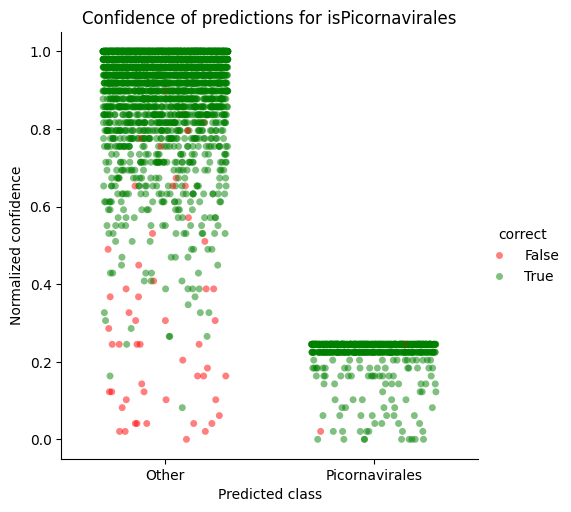

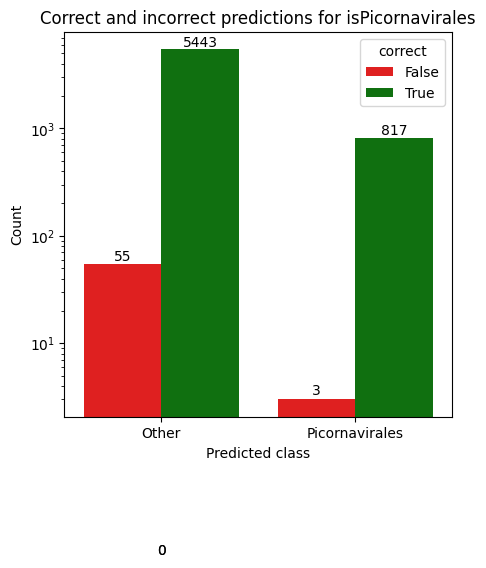

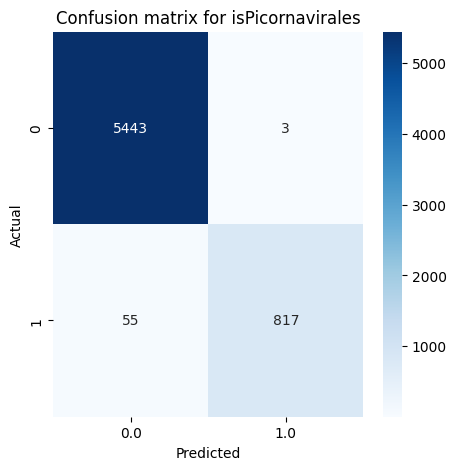

In [22]:
# Prediction plots

# Scatter plot of the predicted probabilities and correct labels
plt.figure(figsize=(5, 5))
sns.catplot(
    x='predictedClass',
    y='confidenceNormalized',
    hue='correct',
    data=pred_genome_nodes,
    kind='strip',
    palette=['red', 'green'],
    alpha=0.5,
    jitter=0.3,
)
plt.xticks(
    ticks=range(2),
    labels=['Other', 'Picornavirales'],
)
plt.xlabel('Predicted class')
plt.ylabel('Normalized confidence')
plt.title(f'Confidence of predictions for {class_label}')
plt.show()


# Histogram of number of correct and incorrect predictions per class
plt.figure(figsize=(5, 5))
sns.countplot(
    x='predictedClass',
    hue='correct',
    data=pred_genome_nodes,
    palette=['red', 'green'],
)
plt.xticks(
    ticks=range(2),
    labels=['Other', 'Picornavirales'],
)
for i in plt.gca().patches:
    plt.gca().text(i.get_x() + i.get_width() / 2, i.get_height() + 0.1, str(int(i.get_height())), ha='center', va='bottom')
plt.yscale('log')
plt.xlabel('Predicted class')
plt.ylabel('Count')
plt.title(f'Correct and incorrect predictions for {class_label}')
plt.show()


# Confusion matrix
confusion_matrix = pd.crosstab(
    pred_genome_nodes[class_label],
    pred_genome_nodes['predictedClass'],
    rownames=['Actual'],
    colnames=['Predicted'],
)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion matrix for {class_label}')
plt.show()


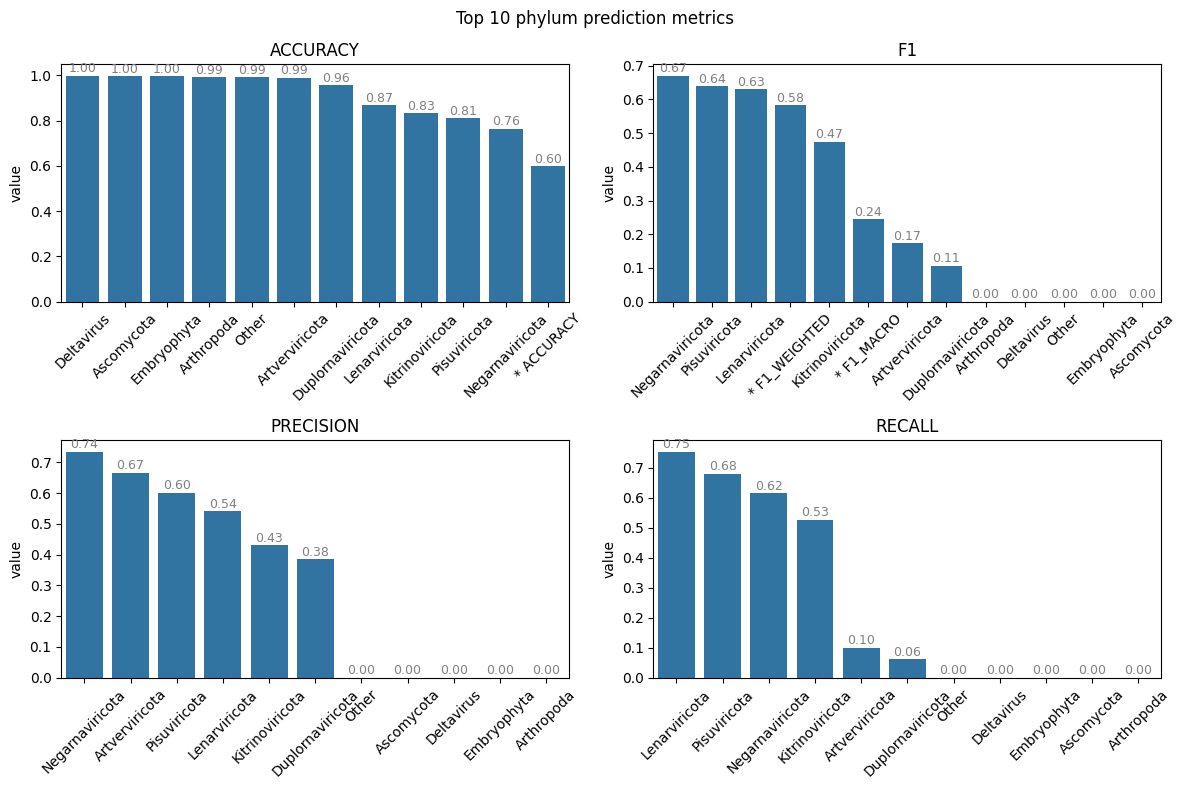

In [35]:
# plot top phylum metrics
target_rank = 'phylum'
k = 10
top_k = nodes.loc[nodes['nodeLabels'] == 'Genome', target_rank].value_counts().index[:k]
label_map = {i: label for i, label in enumerate(top_k)}
label_map[-1] = 'Other'
general_metrics = ['ACCURACY', 'RECALL', 'F1_MACRO', 'F1_WEIGHTED', 'PRECISION']
rows = []

for metric, value in evals['modelInfo']['metrics'].items():
    if 'class_' in metric:
        class_label_id = metric.split('_')[2]
        plylum_label = label_map[int(class_label_id)]
        rows.append({
            'fig': metric.split('_')[0],
            'label': plylum_label,
            'value': value['test'],
        })
    elif metric in general_metrics:
        label = metric
        if metric in ['ACCURACY', 'F1_MACRO', 'F1_WEIGHTED']:
            label = f"* {metric}"
        rows.append({
            'fig': metric.split('_')[0],
            'label': label,
            'value': value['test'],
        })

df_plot = pd.DataFrame(rows)

sorted_metrics = df_plot['fig'].unique().tolist()
sorted_metrics.sort()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, metric in enumerate(sorted_metrics):
    df_metric = df_plot.loc[df_plot['fig'] == metric]
    df_metric = df_metric.sort_values(by='value', ascending=False)
    ax = axes[i // 2, i % 2]
    sns.barplot(data=df_metric, x='label', y='value', ax=ax)
    ax.set_xlabel('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_title(metric)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=9, color='gray', xytext=(0, 5),
            textcoords='offset points')


plt.suptitle(f'Top {k} {target_rank} prediction metrics')
plt.tight_layout()
plt.show()

# fig.savefig(FIGURE_DIR + 'top_phylum_prediction_metrics.png', dpi=300)


Series([], Name: count, dtype: int64)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: isPicornavirales, dtype: float64


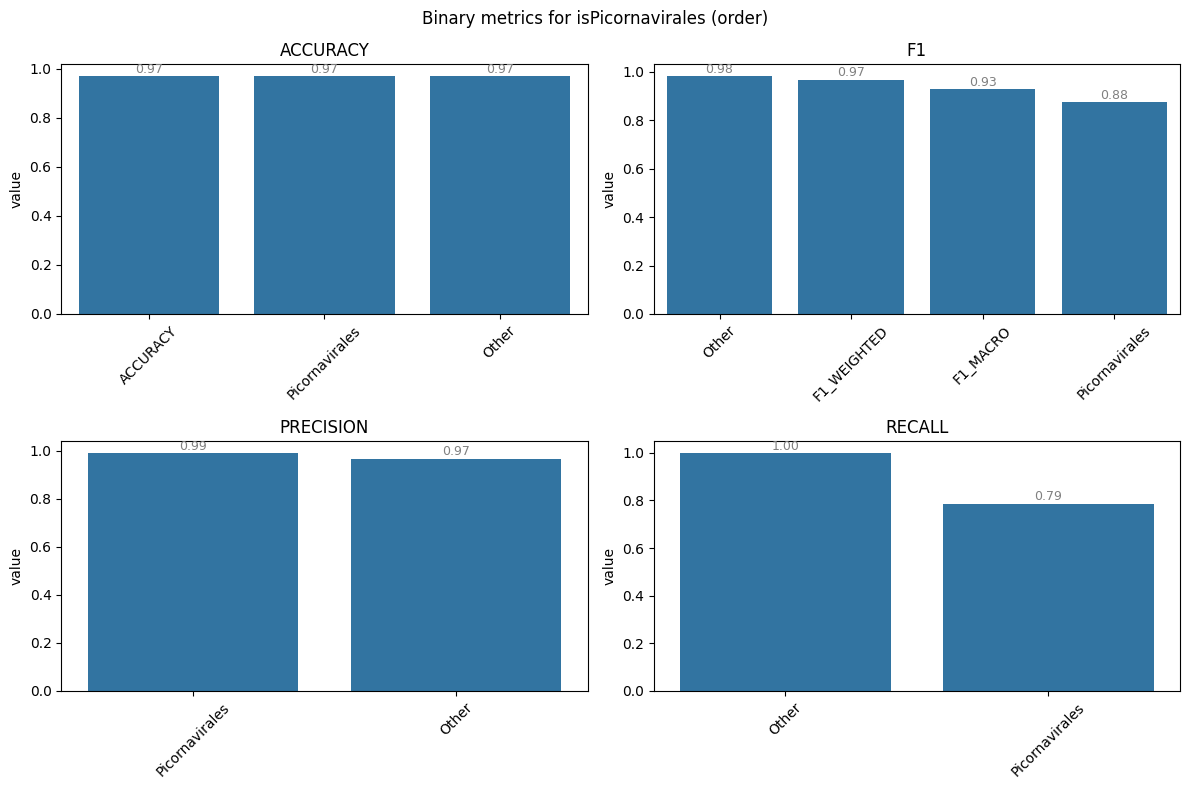

In [13]:
# plot binary classification metrics

# print(nodes.loc[nodes['nodeLabels'] == 'Genome'].describe())

nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
set_class_labels(nodes)

binary_class_labels_map = {
    # 'isPisuviricota': 'phylum',
    'isPicornavirales': 'order',
    # 'isEllioviricetes': 'order',
    # 'isPicornaviridae': 'family',
    # 'isOrthoflavivirus': 'genus',
}
general_metrics = ['RECALL', 'PRECISION', 'ACCURACY', 'F1_MACRO', 'F1_WEIGHTED']

for binary_class_label, tax_rank in binary_class_labels_map.items():
    rows = []
    binary_evals = pd.read_csv(EVALS_DIR + binary_class_label + '_evals.csv')
    metric_rows =  ast.literal_eval(binary_evals['0'][2])['metrics']

    for metric, value in metric_rows.items():
        if 'class_' in metric:
            class_label_id = metric.split('_')[2]
            label = binary_class_label.split('is')[1] if class_label_id == '1' else 'Other'
            rows.append({
                'fig': metric.split('_')[0],
                'label': label,
                'value': value['test'],
            })
        elif metric in general_metrics:
            rows.append({
                'fig': metric.split('_')[0],
                'label': metric,
                'value': value['test'],
            })

    value_counts = nodes.loc[nodes['nodeLabels'] == 'Genome', binary_class_label].value_counts()
    describe_stats = nodes.loc[nodes['nodeLabels'] == 'Genome', binary_class_label].describe()
    print(value_counts)
    print(describe_stats)

    df_plot = pd.DataFrame(rows)
    sorted_metrics = df_plot['fig'].unique().tolist()
    sorted_metrics.sort()

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, metric in enumerate(sorted_metrics):
        df_metric = df_plot.loc[df_plot['fig'] == metric]
        df_metric = df_metric.sort_values(by='value', ascending=False)
        ax = axes[i // 2, i % 2]
        sns.barplot(data=df_metric, x='label', y='value', ax=ax)
        ax.set_xlabel('')
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.set_title(metric)
        # add value text on top of each bar
        for p in ax.patches:
            ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=9, color='gray', xytext=(0, 5),
                        textcoords='offset points')


    fig.suptitle(f'Binary metrics for {binary_class_label} ({tax_rank})')
    plt.tight_layout()
    plt.show()
    # fig.savefig(FIGURE_DIR + binary_class_label + '_prediction_metrics.png', dpi=300)


# print(nodes.loc[nodes['nodeLabels'] == 'Genome', 'isPisuviricota'].value_counts())


In [14]:
gds.graph.drop(get_projection_name())
gds.beta.model.drop(gds.model.get(model_encoder))
gds.beta.pipeline.drop(gds.pipeline.get(pipeline_name))

pipelineInfo    {'splitConfig': {'testFraction': 0.3, 'validat...
pipelineName                            taxon_prediction_pipeline
pipelineType                Node classification training pipeline
creationTime                  2024-04-25T16:02:54.945837680+00:00
Name: 0, dtype: object